## Credit Card Anomaly Detection with Autoencoders and Isolation Forest

In the previous notebook, we've engineered features that reflect behavioral and amount-based factors (RFM) of the credit card dataset. We've examined the distributions within each feature and conducted rule-based benchmarking to detect outliers. Now we will apply more advanced methodologies to the same dataset, namely autoencoders and isolation forest. We will recreate some of the features we did in the previous notebook, to prevent data leakage. We will then go over how these models work, discuss and assess the strengths of each model, and compare the results.

In [62]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split    
from sklearn.ensemble import RandomForestClassifier    
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

from pyod.models.auto_encoder import AutoEncoder
from pyod.models.iforest import IForest


In [63]:
#load and prep dataset
pd.set_option("display.max_columns", None)

df = pd.read_csv("purchase_credit_card.csv")

df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])
df = df.sort_values('Transaction Date')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 442458 entries, 31364 to 410511
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Year-Month                    442458 non-null  int64         
 1   Agency Number                 442458 non-null  int64         
 2   Agency Name                   442458 non-null  object        
 3   Cardholder Last Name          442458 non-null  object        
 4   Cardholder First Initial      442458 non-null  object        
 5   Description                   442458 non-null  object        
 6   Amount                        442458 non-null  float64       
 7   Vendor                        442458 non-null  object        
 8   Transaction Date              442458 non-null  datetime64[ns]
 9   Posted Date                   442458 non-null  object        
 10  Merchant Category Code (MCC)  442458 non-null  object        
dtypes: datetime64[

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3440581480.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Transaction Date"] = pd.to_datetime(df["Transaction Date"])


## Feature Engineering Strategy for Unsupervised Models

First and foremost, we would need to split the data into train and test sets. Only then can we perform feature engineering. This is to make sure that our test or validation set is as pure and as unseen as possible. Preparing features before splitting would cause data leakage, meaning that we would be training on some of the data that will end up in the test set.

In [64]:
# Find a split point in time (e.g., using the 80th percentile of the date)
split_date = df['Transaction Date'].quantile(0.8, interpolation='nearest')

# Split on date
train_df = df[df['Transaction Date'] < split_date].copy()
test_df = df[df['Transaction Date'] >= split_date].copy()

Here, we are splitting by time. That is to simulate the reality of deployment where the data points aren't shuffled randomly. We would be using the past to predict new transactions as they come in. After splitting, we are going to recreate some of the features we have from the previous notebook.

# Train features

In [65]:
#row-wise features
train_df["Week_Number"] = train_df["Transaction Date"].dt.isocalendar().week
train_df["Year"] = train_df["Transaction Date"].dt.year
train_df["cardholder_full_name"] = train_df["Cardholder First Initial"] + " " + train_df["Cardholder Last Name"]


# Amount Mean
amount_mean_map = train_df.groupby("cardholder_full_name")["Amount"].mean()
train_df["Amount Mean"] = train_df["cardholder_full_name"].map(amount_mean_map)


# mean_tx_per_week
weekly_counts_train = train_df.groupby(["cardholder_full_name", "Year", "Week_Number"]).size().reset_index(name="weekly_tx_count")
mean_weekly_freq_map = weekly_counts_train.groupby("cardholder_full_name")["weekly_tx_count"].mean()
train_df["mean_tx_per_week"] = train_df["cardholder_full_name"].map(mean_weekly_freq_map)
train_df["mean_tx_per_week"].fillna(0, inplace=True)

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/1191371399.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["mean_tx_per_week"].fillna(0, inplace=True)


# Test features

In [66]:
#row-wise features
test_df["Week_Number"] = test_df["Transaction Date"].dt.isocalendar().week
test_df["Year"] = test_df["Transaction Date"].dt.year
test_df["cardholder_full_name"] = test_df["Cardholder First Initial"] + " " + test_df["Cardholder Last Name"]


# Amount Mean
test_df["Amount Mean"] = test_df["cardholder_full_name"].map(amount_mean_map)
global_amount_mean = train_df["Amount"].mean()
test_df["Amount Mean"].fillna(global_amount_mean, inplace=True)


# mean_tx_per_week
test_df["mean_tx_per_week"] = test_df["cardholder_full_name"].map(mean_weekly_freq_map)
test_df["mean_tx_per_week"].fillna(0, inplace=True)

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/1226093957.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df["Amount Mean"].fillna(global_amount_mean, inplace=True)
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/1226093957.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are se

Whatever processes we do on our train set, we will have to replicate on our test set as well. This is to make sure we are comparing uniform features and uniform computations, but that we are mindful of data leakages.

For unsupervised modeling approaches, it's important to clean the dataset to include only the most relevant numeric columns, because the models don't understand anything that's not numeric. Categorical variables can be encoded, but for this analysis, we'll choose to drop them. The reason for mentioning relevancy is that any numeric input that's not relevant, like "Agency Number", won't be treated as a category by the model, but instead as a literal number, so a higher or lower value than usual will influence the model and potentially be flagged as an outlier.

Another key challenge we have to address is cardholder-specific information. We emphasized recency, frequency, and monetary (RFM) measures, but those only work when benchmarked against each cardholder's previous habits. We already did this in our earlier feature engineering notebook, where we grouped the computations by cardholder and calculated ratios for some metrics as well. In the same spirit, we’ll need to imply cardholder-specific information in the inputs we feed the model. The reason is that the models can't trace a feature back to a cardholder’s habits on their own. Say cardholder A’s mean spend is $195 and cardholder B’s is $50. A $200 transaction is normal for A but unusual for B. The model has no way of knowing that unless we frame the features in a way that helps it understand. Let's recap on what we have so far.

We already have some insightful features here. To answer the above question though, how would we add cardholder context to our models? The answer lies in ratios and z-scores, specifically for the Amount feature. We are going to benchmark the Amounts for each cardholder to their own means, and also compute z-scores. These are similar approaches, but why we want both is that the z-score adds statistical context to the volatility of their spending. Two cardholders might have the same means, but completely different standard deviations. Therefore, what's anomalous to these cardholders might be different.

In [67]:
## train set z-score
train_df['amount_ratio'] = train_df['Amount'] / (train_df['Amount Mean'] + 1e-6)

cardholder_std_map = train_df.groupby('cardholder_full_name')['Amount'].std()
train_df['Amount Std'] = train_df['cardholder_full_name'].map(cardholder_std_map)
train_df['amount_z_score'] = (train_df['Amount'] - train_df['Amount Mean']) / (train_df['Amount Std'] + 1e-6)
train_df['amount_z_score'].fillna(0, inplace=True)

## test set z-score
test_df['amount_ratio'] = test_df['Amount'] / (test_df['Amount Mean'] + 1e-6)


test_df['Amount Std'] = test_df['cardholder_full_name'].map(cardholder_std_map)
global_amount_std = train_df['Amount'].std()
test_df['Amount Std'].fillna(global_amount_std, inplace=True)
test_df['amount_z_score'] = (test_df['Amount'] - test_df['Amount Mean']) / (test_df['Amount Std'] + 1e-6)
test_df['amount_z_score'].fillna(0, inplace=True)

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/787365164.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['amount_z_score'].fillna(0, inplace=True)
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/787365164.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

These are great features for "how much", but we also need a "how often" measure. We already have a "mean_tx_per_week", which is a great benchmark. This represents a cardholder's historical mean number of transactions per week, and we need a current observation to compare it to. We can compute "days_since_last_tx", conclude when a transaction is expected based on "mean_tx_per_week", then compare the actual time gap to the expected time gap. We can call it a frequency ratio.

In [68]:
##train set frequency ratio

train_df = train_df.sort_values(['cardholder_full_name', 'Transaction Date'])

#Calculate the days since the last transaction for each cardholder
train_df['days_since_last_tx'] = train_df.groupby('cardholder_full_name')['Transaction Date'].diff().dt.days.fillna(0)

#Calculate the expected days between transactions, then the frequency ratio
train_df['expected_days_between_tx'] = 7 / (train_df['mean_tx_per_week'] + 1e-6)
train_df['frequency_ratio'] = train_df['days_since_last_tx'] / train_df['expected_days_between_tx']
train_df['frequency_ratio'].fillna(1, inplace=True)

##repeat for test set
test_df = test_df.sort_values(['cardholder_full_name', 'Transaction Date'])
test_df['days_since_last_tx'] = test_df.groupby('cardholder_full_name')['Transaction Date'].diff().dt.days.fillna(0)
test_df['expected_days_between_tx'] = 7 / (test_df['mean_tx_per_week'] + 1e-6)
test_df['frequency_ratio'] = test_df['days_since_last_tx'] / test_df['expected_days_between_tx']
test_df['frequency_ratio'].fillna(1, inplace=True)

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3602195232.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['frequency_ratio'].fillna(1, inplace=True)
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3602195232.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values

A number close to 1 would mean that the transaction occurred as expected, or as it had occurred in previous weeks. A value much less than 1 shows that the "rhythm" of the cardholders changed, and thus will be more anomalous. Now that we have these new features, we can start preparing a model-ready dataset by subsetting for only features that we need.

In [69]:
#log amount
train_df['log_amount'] = np.log1p(train_df['Amount'])

#final selection
final_model_features = [
    'Amount',
    'days_since_last_tx',
    'amount_ratio',
    'amount_z_score',
    'frequency_ratio',
    'log_amount'
]

#modeling dataset for train
X_train = train_df[final_model_features].copy()
X_train.fillna(0, inplace=True)

print("Final Training Set Features:")
print(X_train.head())
print("\n")
X_train.info()

#repeat for test set
test_df['log_amount'] = np.log1p(test_df['Amount'])
X_test = test_df[final_model_features].copy()
X_test.fillna(0, inplace=True)

print("Final Test Set Features:")
print(X_test.head())
print("\n")
X_test.info()

Final Training Set Features:
         Amount  days_since_last_tx  amount_ratio  amount_z_score  \
295887  4626.46                 0.0      1.000000        0.000000   
95546     16.90                 0.0      0.060702       -0.448881   
95555   1796.09                10.0      6.451264        2.605101   
95614     14.53                21.0      0.052189       -0.452949   
95635    734.50                11.0      2.638205        0.782881   

        frequency_ratio  log_amount  
295887         0.000000    8.439763  
95546          0.000000    2.884801  
95555          1.587303    7.493924  
95614          3.333336    2.742774  
95635          1.746033    6.600551  


<class 'pandas.core.frame.DataFrame'>
Index: 352538 entries, 295887 to 297736
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Amount              352538 non-null  float64
 1   days_since_last_tx  352538 non-null  float64
 2   amount_rati

/opt/anaconda3/envs/finance_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/finance_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/finance_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/envs/finance_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


This is our final selection. We add one more feature for the absolute number of "Amount", to support our ratios. We use log "Amount" to mitigate the skew. We drop everything else because they are either objects/categoricals or irrelevant floats. This selection will be used for both our autoencoder and the isolation forest. Before we start setting up the autoencoder, we first need to scale the features. The reason why is that our features are on different scales. "Amount" can go to the thousands, yet our ratios will most likely have a single digit mean. We would want these features to contribute equally to the model. Let's also clean up some infinity values as well here, because some of our features have very small divisors.

In [70]:
# Clean up infinity
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# fill any resulting NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


# Scale train and test set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## What are Autoencoders and How Do They Work?

An autoencoder is a special type of neural network that learns to compress your data into a smaller representation and then reconstruct it back to its original form. It’s kind of like a data compression tool, but the main idea is that it learns patterns in your credit card dataset without using any labels. The network has three main parts: an encoder that reduces the original features down to a smaller bottleneck layer (for example, from 8 features down to 4, which we’ll see below), and a decoder that tries to rebuild the original data from this compressed version. During training, the autoencoder learns to reconstruct “normal” records by minimizing the difference between the input and output.

Once the model is trained, we can feed new data through it. Records that are significantly different from the usual patterns, like very high amounts or strange combinations—will have higher reconstruction errors, because the autoencoder just can’t recreate them as well. This reconstruction error becomes our anomaly score. For credit card payments, this is useful because fraudulent or outlier transactions often look different from regular ones, so they show up with high reconstruction errors, even if we don’t have labels for what’s “fraud.”

As previously mentioned, we engineered several ratio and Z-score features, instead of just using the raw transaction values. These features are created by comparing a transaction to the historical statistics (like mean and standard deviation) of that specific cardholder, so they help track individual behavior. The model can’t actually allocate the transactions to a specific cardholder since we removed the names and descriptive columns, but by keeping these ratio features, they end up working a bit like a built-in weight per cardholder. Now we can get started with the training.

In [71]:
# In PyOD, hidden_neurons = [encoder_layers, bottleneck, encoder_layers_reversed]
# You only need to provide the first half, e.g., [8, 4] for an [8, 4, 8] architecture.

ae1 = AutoEncoder(
    hidden_neuron_list=[8, 4],  # Defines the [8, 4, 8] structure
    contamination=0.05,
    epoch_num=100,
    batch_size=32,
    verbose=1,
    random_state=42
)

ae2 = AutoEncoder(
    hidden_neuron_list=[12, 6], # Defines the [12, 6, 12] structure
    contamination=0.05,
    epoch_num=120,
    batch_size=64,
    verbose=1,
    random_state=7
)

ae3 = AutoEncoder(
    hidden_neuron_list=[16, 8], # Defines the [16, 8, 16] structure
    contamination=0.05,
    epoch_num=80,
    batch_size=32,
    verbose=1,
    random_state=99
)

## Rationale for Parameters

Our autoencoder architecture uses several important parameters that control how it learns to detect anomalies in our data. The hidden_neuron_list defines our network structure, starting with 8 neurons (matching our 8 healthcare features), compressing down to 4 neurons in the middle bottleneck layer that forces the model to learn only the most essential patterns, then expanding back to 8 to reconstruct the original data, essentially pushing all transaction records through a narrow funnel that keeps only critical information.  The training process is controlled by epoch_num=100 (the model sees our entire dataset 100 times) and batch_size=32 (processing 32 records at a time for efficient learning). The training process is controlled by epochs=100 (the model sees our entire dataset 100 times) and batch_size=32 (processing 32 records at a time for efficient learning). The model uses the Adam optimizer by default, which is an adaptive learning rate algorithm. It maintains separate learning rates for each parameter by computing exponential moving averages of both the gradients and their squared values, allowing it to automatically adjust step sizes during training and converge faster than standard gradient descent.

In [34]:
# Assuming ae1, ae2, ae3, X_train_scaled, and X_test_scaled are already defined

print("--- Fitting Autoencoder Models ---")
ae1.fit(X_train_scaled)
ae2.fit(X_train_scaled)
ae3.fit(X_train_scaled)

--- Fitting Autoencoder Models ---


Training: 100%|█████████████████████████████| 80/80 [14:36:33<00:00, 657.42s/it]


To get a more robust result, we're aggregating the anomaly scores from our three autoencoder models. Each model gives a score to every transaction, but since they have different hyperparameters, their raw scores might be on completely different scales. If we just naively averaged them, the result could be dominated by the model that simply outputs higher numbers. To combine them fairly, we first standardize the scores before taking the mean.

The contamination rate, which we'll set to 0.05, tells our process to assume that 5% of the transactions are anomalies. This is a crucial tuning knob that controls the precision-recall tradeoff. A lower contamination rate sets a stricter bar for what counts as an anomaly. This gives you high precision—meaning the flagged items are very likely real anomalies—but you risk missing more subtle cases (low recall). Conversely, a higher rate "casts a wider net" to catch more potential anomalies (high recall), but the tradeoff is lower precision, as you'll likely flag more normal transactions by mistake.

The right balance depends entirely on the business use case and tolerance for risk.

In [72]:
from pyod.utils.utility import standardizer
from pyod.models.combination import average
import numpy as np

## train set anomaly scores
# The decision_scores_ attribute holds the scores for the data the model was fitted on.
train_scores = np.column_stack([
    ae1.decision_scores_,
    ae2.decision_scores_,
    ae3.decision_scores_
])

# standardize and average scores
train_scores_norm = standardizer(train_scores)
train_agg_scores = average(train_scores_norm)

# threshold selection
contamination = 0.05
threshold = np.percentile(train_agg_scores, 100 * (1 - contamination))

print(f"\nAnomaly threshold learned from training data: {threshold:.4f}")

# predict on test set
test_scores = np.column_stack([
    ae1.decision_function(X_test_scaled),
    ae2.decision_function(X_test_scaled),
    ae3.decision_function(X_test_scaled)
])

# standardize and average scores
test_scores_norm = standardizer(test_scores)
test_agg_scores = average(test_scores_norm)

# apple threshold to test scores
test_anomaly_labels = (test_agg_scores > threshold).astype(int)

# add back results to test_df for further analysis
test_df['autoencoder_anomaly_score'] = test_agg_scores
test_df['autoencoder_anomaly_label'] = test_anomaly_labels

print(f"\nNumber of anomalies found in the test set: {np.sum(test_anomaly_labels)}")

# top anomalies found in the test set
print("\n--- Top 10 Anomalies Found in Test Set")
print(test_df.sort_values('autoencoder_anomaly_score', ascending=False).head(15))

AttributeError: 'AutoEncoder' object has no attribute 'decision_scores_'

The next block applies the same process to the test set. We get the anomaly scores from each of the three models, then standardize and average them just like we did for the training data. The key difference is that we now apply the threshold we already learned from the train set to this new, unseen data. This step tags the anomalies in our test set, simulating how the model would perform in the real world. Finally, we add the anomaly scores and labels back to our test_df so we can sift through the flagged transactions. Here, we'll display the top 10.

Just as a quick sanity check, we can see if the features at least look anomalous for these ten transactions. Let's pick out two random cardholders, and loop through each to look deeper into distributions. We are going to compare what the model saw on the train set, and what it predicted based off of on the test set.

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3051182984.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3051182984.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3051182984.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3051182984.py:39: UserWarning: set_ticklabels() should only be used with a fixed number o

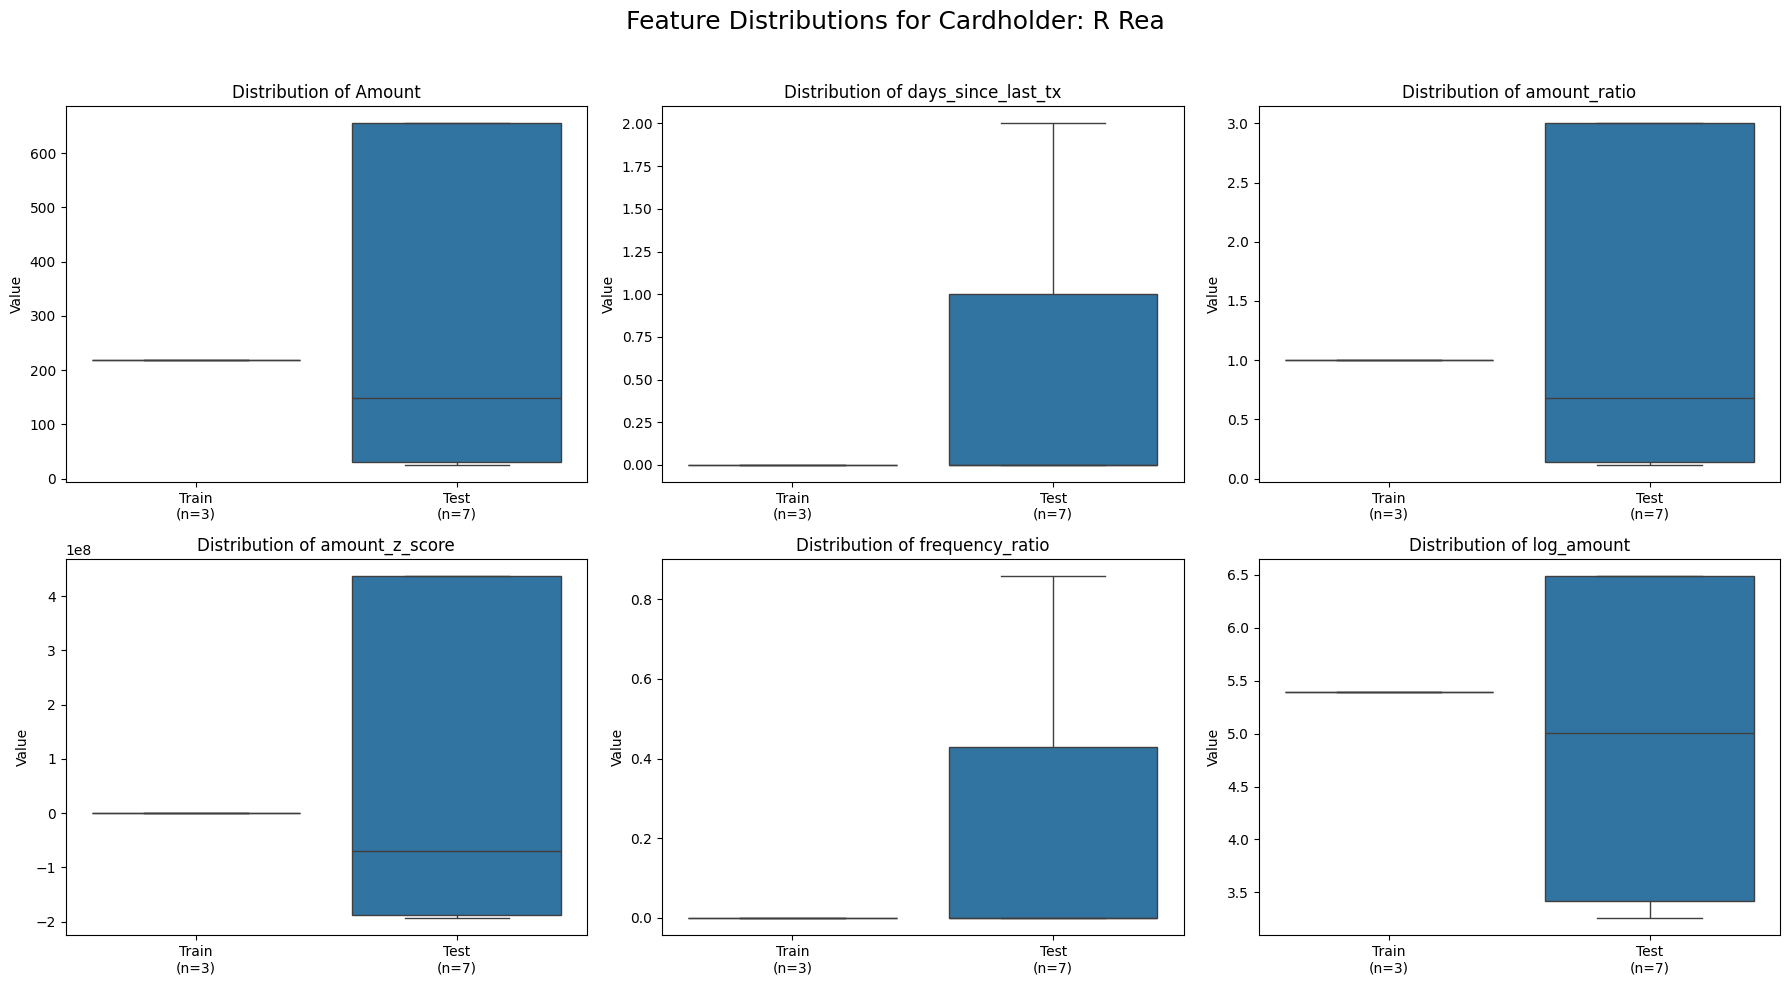

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3051182984.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3051182984.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3051182984.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/3051182984.py:39: UserWarning: set_ticklabels() should only be used with a fixed number o

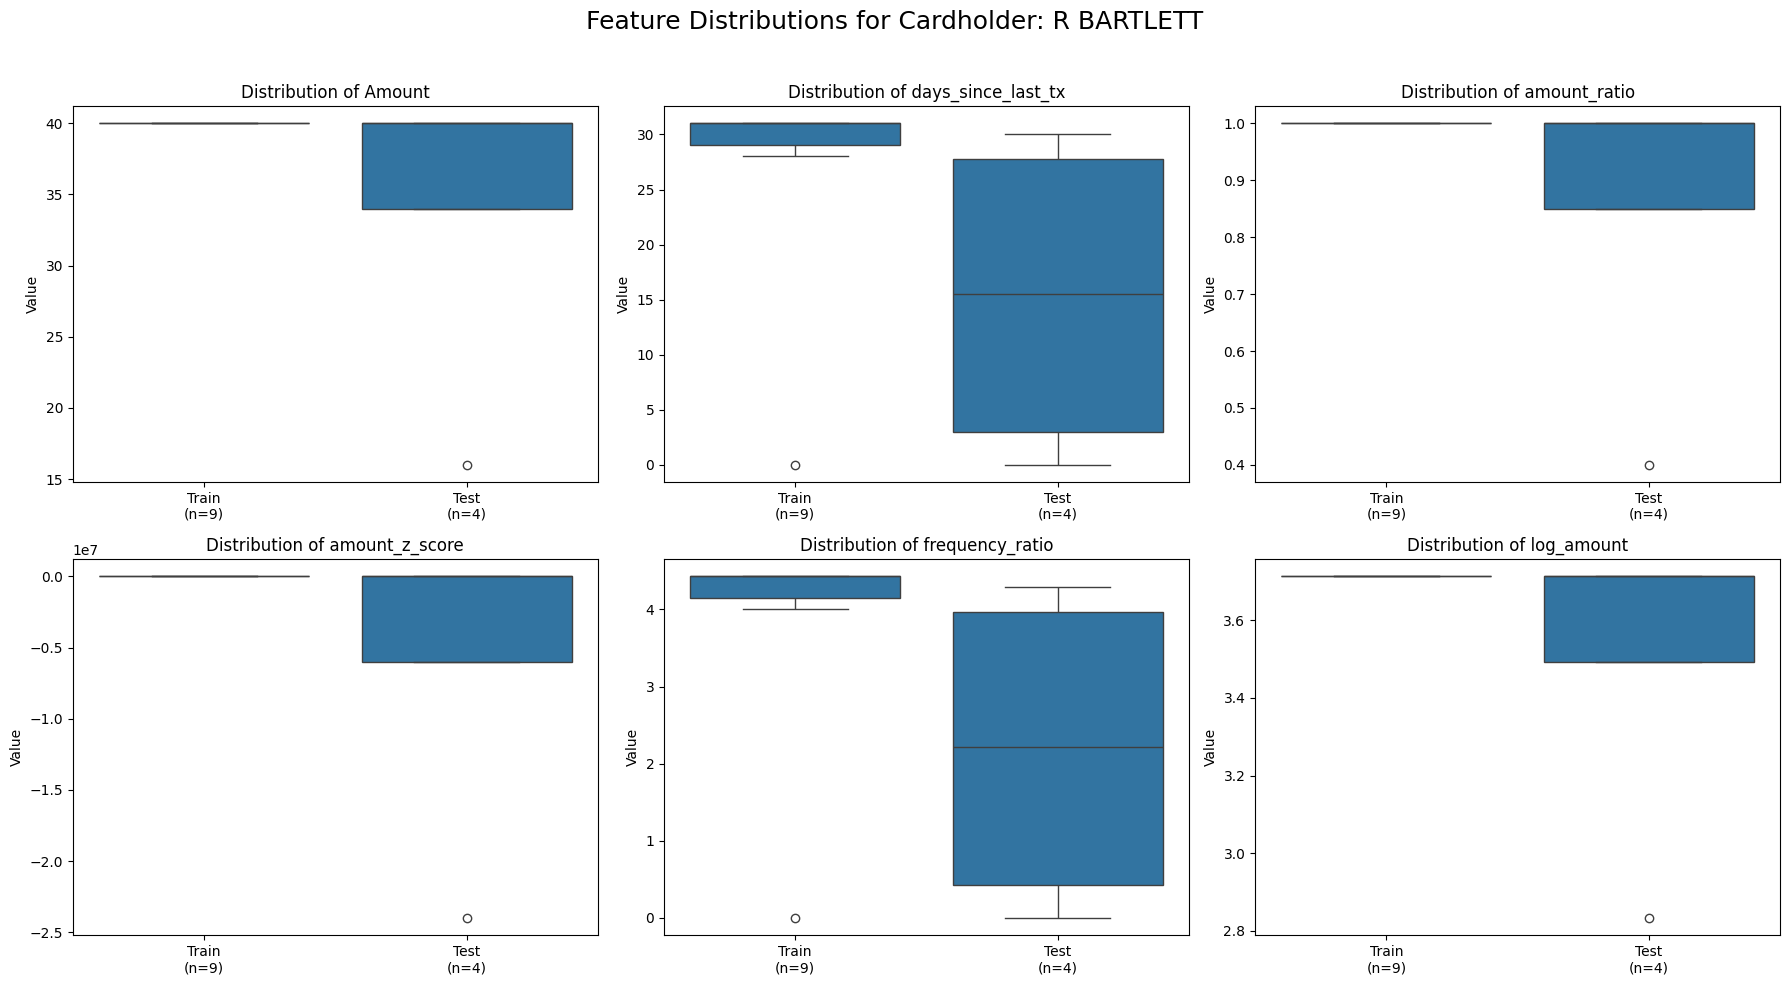

In [73]:
# take initial model features
final_model_features = [
    'Amount',
    'days_since_last_tx',
    'amount_ratio',
    'amount_z_score',
    'frequency_ratio',
    'log_amount'
]

# list of cardholders to analyze
users_to_plot = ["R Rea", "R BARTLETT"]

# loop through each cardholder to generate a set of plots
for user in users_to_plot:
    user_train = train_df[train_df["cardholder_full_name"] == user].copy()
    user_test = test_df[test_df["cardholder_full_name"] == user].copy()

    # count of observations
    n_train = len(user_train)
    n_test = len(user_test)

    # combine train and test sets for easy plotting
    user_train['set'] = 'Train'
    user_test['set'] = 'Test'
    user_combined = pd.concat([user_train, user_test])

    # plotting
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Feature Distributions for Cardholder: {user}', fontsize=18)
    axes = axes.flatten()

    for i, feature in enumerate(final_model_features):
        ax = axes[i]
        sns.boxplot(x='set', y=feature, data=user_combined, ax=ax)
        ax.set_title(f'Distribution of {feature}')
        ax.set_xlabel('')
        ax.set_ylabel('Value')
        ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

These visualizations reveal a clear behavioral shift for the flagged cardholders, with the feature distributions in the test set looking starkly different from the training set. This change is often driven by a standard deviation of zero in the training data, which happens when a user's transactions are consistently for the same amount, like a recurring subscription. While we can't be certain if this is fraud, the model has successfully flagged what it was designed to find: a significant change in behavior. The clear next step is to investigate these transactions with the cardholders to determine if they are legitimate. One last thing, we will plot histograms for the distributions of the anomaly scores within the train and test sets to observe the distribution.

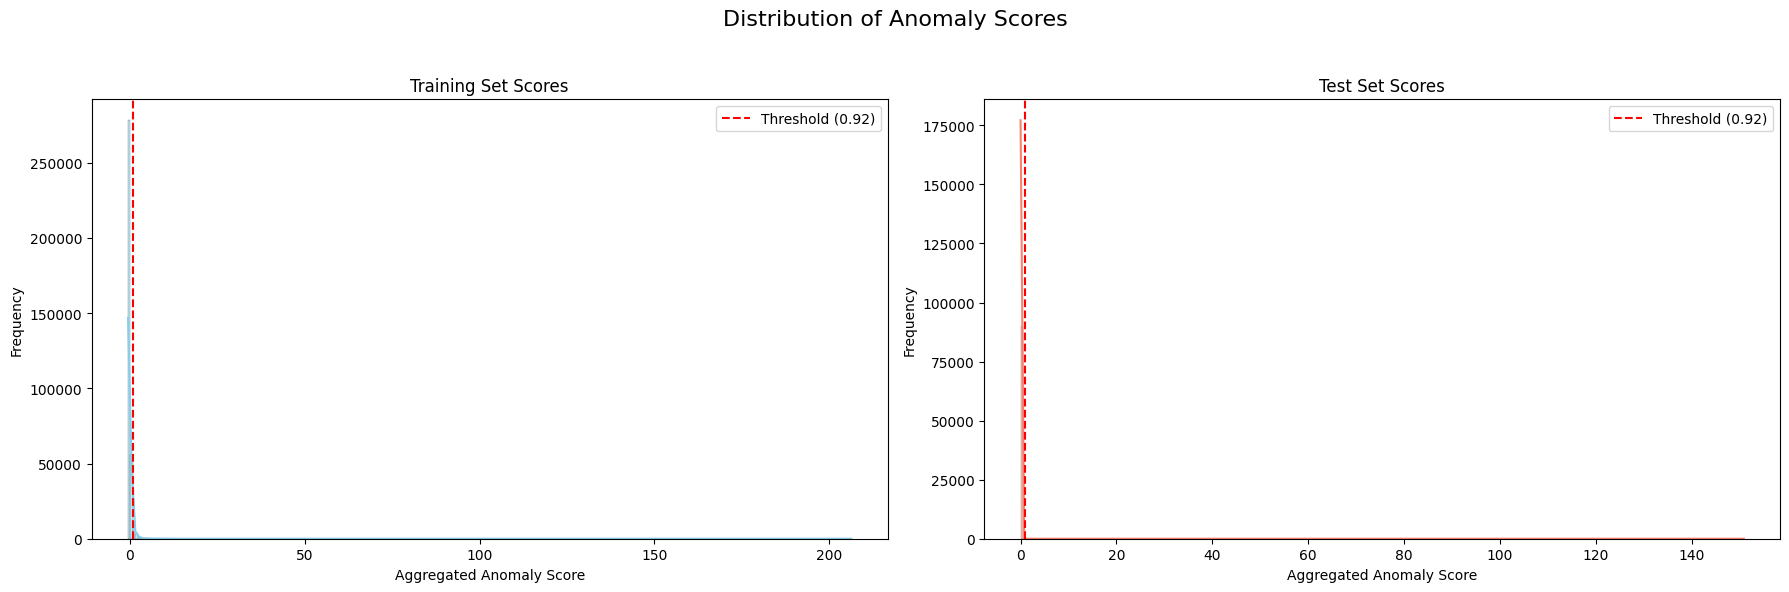

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Distribution of Anomaly Scores', fontsize=16)

# train set
sns.histplot(train_agg_scores, bins=300, ax=axes[0], color='skyblue', kde=True)
axes[0].axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')
axes[0].set_title('Training Set Scores')
axes[0].set_xlabel('Aggregated Anomaly Score')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# test set
sns.histplot(test_agg_scores, bins=300, ax=axes[1], color='salmon', kde=True)
axes[1].axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.2f})')
axes[1].set_title('Test Set Scores')
axes[1].set_xlabel('Aggregated Anomaly Score')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The scores in the training set are concentrated at very low values, which makes sense since the contamination rate is 5% and our threshold score based on this was 0.92. The actual anomalies, however, seem to have scores all the way up to 200 for the train set, and 140 for the test set. These confirm that the model is identifying a significant difference in behavior between anomalies and non-anomalies. Let's explore the same concept with another model, the isolation forest.

## What are Isolation Forests?

An Isolation Forest is an ensemble tree model, much like a Random Forest. This means the model builds many random trees, and each tree is made of its own splits, or "branches," that separate the data points. While a Random Forest uses its trees to classify observations into a specific bucket, an Isolation Forest has a different goal: it tries to find outliers.

The key idea is that anomalies are easier to isolate than normal points. Think of trying to describe the location of one person in a crowded room. If the person is standing all by themselves in a corner (an anomaly), it's easy; you only need one or two instructions. If they're in the middle of a dense crowd (a normal point), it takes many more instructions to single them out.

That's how the algorithm works. For each tree, it randomly selects a feature and then a random split point for that feature, continuing until the data point is isolated. The model then looks at the data points that take the least amount of splits to be separated from the rest of the set. This makes sense because a data point is easy to separate only if it's far from the other points. In other words, it's an anomaly.

Instead of having the trees "vote" like in a Random Forest, the Isolation Forest averages the path length (the number of splits) for each data point across all the trees. This average path length is then used to calculate a final anomaly score for each transaction. Points with a shorter average path length get a higher score, marking them as more likely to be anomalous.

In [57]:
#loop to test different values for the 'max_samples' hyperparameter
print("Evaluating IForest with different max_samples")

for samples in [200, 400, 600]:
    model = IForest(contamination=0.05, max_samples=samples, random_state=42)
    model.fit(X_train_scaled)
    test_scores = model.decision_function(X_test_scaled)
    print(f"max_samples = {samples} => Mean anomaly score on test set: {np.mean(test_scores):.4f}")

Evaluating IForest with different max_samples
max_samples = 200 => Mean anomaly score on test set: -0.1725
max_samples = 400 => Mean anomaly score on test set: -0.1534
max_samples = 600 => Mean anomaly score on test set: -0.1505


As mentioned previously, an Isolation Forest is already an ensemble model by nature. A single model is built from a collection of many individual trees, which means we do not need to aggregate our results like we did with the autoencoder. This time around, a key hyperparameter is max_samples. Since the model works by building random trees on random subsets of the data, the size of each subset affects the scores significantly. For example, max_samples = 200 means that for each tree, the model will randomly select 200 rows from the train set and build that tree using only those samples. By default, this process is repeated 100 times for a total of 100 trees, which we will keep constant here.

The code is short and simple this time, as we are just trying out different max_samples values and looking at the mean anomaly scores on our test set. Since our set is unlabeled, this mean score doesn't signify performance, but it can suggest how well the model is separating outliers from normal data. A higher mean score generally means that the model is assigning higher scores to truly anomalous points, creating better separation. Let's pick max_samples = 200 and observe the top 10 flagged transactions.

In [59]:
iforest_final = IForest(
    n_estimators=100,
    max_samples=200,
    contamination=0.05,
    random_state=42
)
iforest_final.fit(X_train_scaled)

test_scores_iforest = iforest_final.decision_function(X_test_scaled)
test_labels_iforest = iforest_final.predict(X_test_scaled) 

# add the results back to the original test_df for analysis
test_df['iforest_anomaly_score'] = test_scores_iforest
test_df['iforest_anomaly_label'] = test_labels_iforest

#display the top 10 transactions with the highest anomaly scores
print(f"\n--- Top 10 Anomalies Found by Isolation Forest (max_samples={200})")
print(test_df.sort_values('iforest_anomaly_score', ascending=False).head(10))


--- Top 10 Anomalies Found by Isolation Forest (max_samples=200)
        Year-Month  Agency Number                               Agency Name  \
367801      201405           1000                 OKLAHOMA STATE UNIVERSITY   
405811      201406          53000               OKLA. PANHANDLE STATE UNIV.   
397765      201406          32000       DEPARTMENT OF WILDLIFE CONSERVATION   
400124      201405          34500              DEPARTMENT OF TRANSPORTATION   
397698      201406          32000       DEPARTMENT OF WILDLIFE CONSERVATION   
389407      201406           4000  DEPARTMENT OF AGRICULTURE, FOOD, ANF FOR   
407481      201405          56600      DEPARTMENT OF TOURISM AND RECREATION   
397947      201406          32000       DEPARTMENT OF WILDLIFE CONSERVATION   
394785      201405          15000              UNIV.OF SCIENCE & ARTS OF OK   
429888      201405          77000     UNIV. OF OKLA. HEALTH SCIENCES CENTER   

       Cardholder Last Name Cardholder First Initial  \
367801  

Interestingly, we have a completely different list than when we did our autoencoders. It's likely the case that our models are capturing different types of suspicious behaviours, even with the same features. Let's pick two cardholders at random and zoom in further on their distributions.

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/2675217880.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/2675217880.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/2675217880.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/2675217880.py:38: UserWarning: set_ticklabels() should only be used with a fixed number o

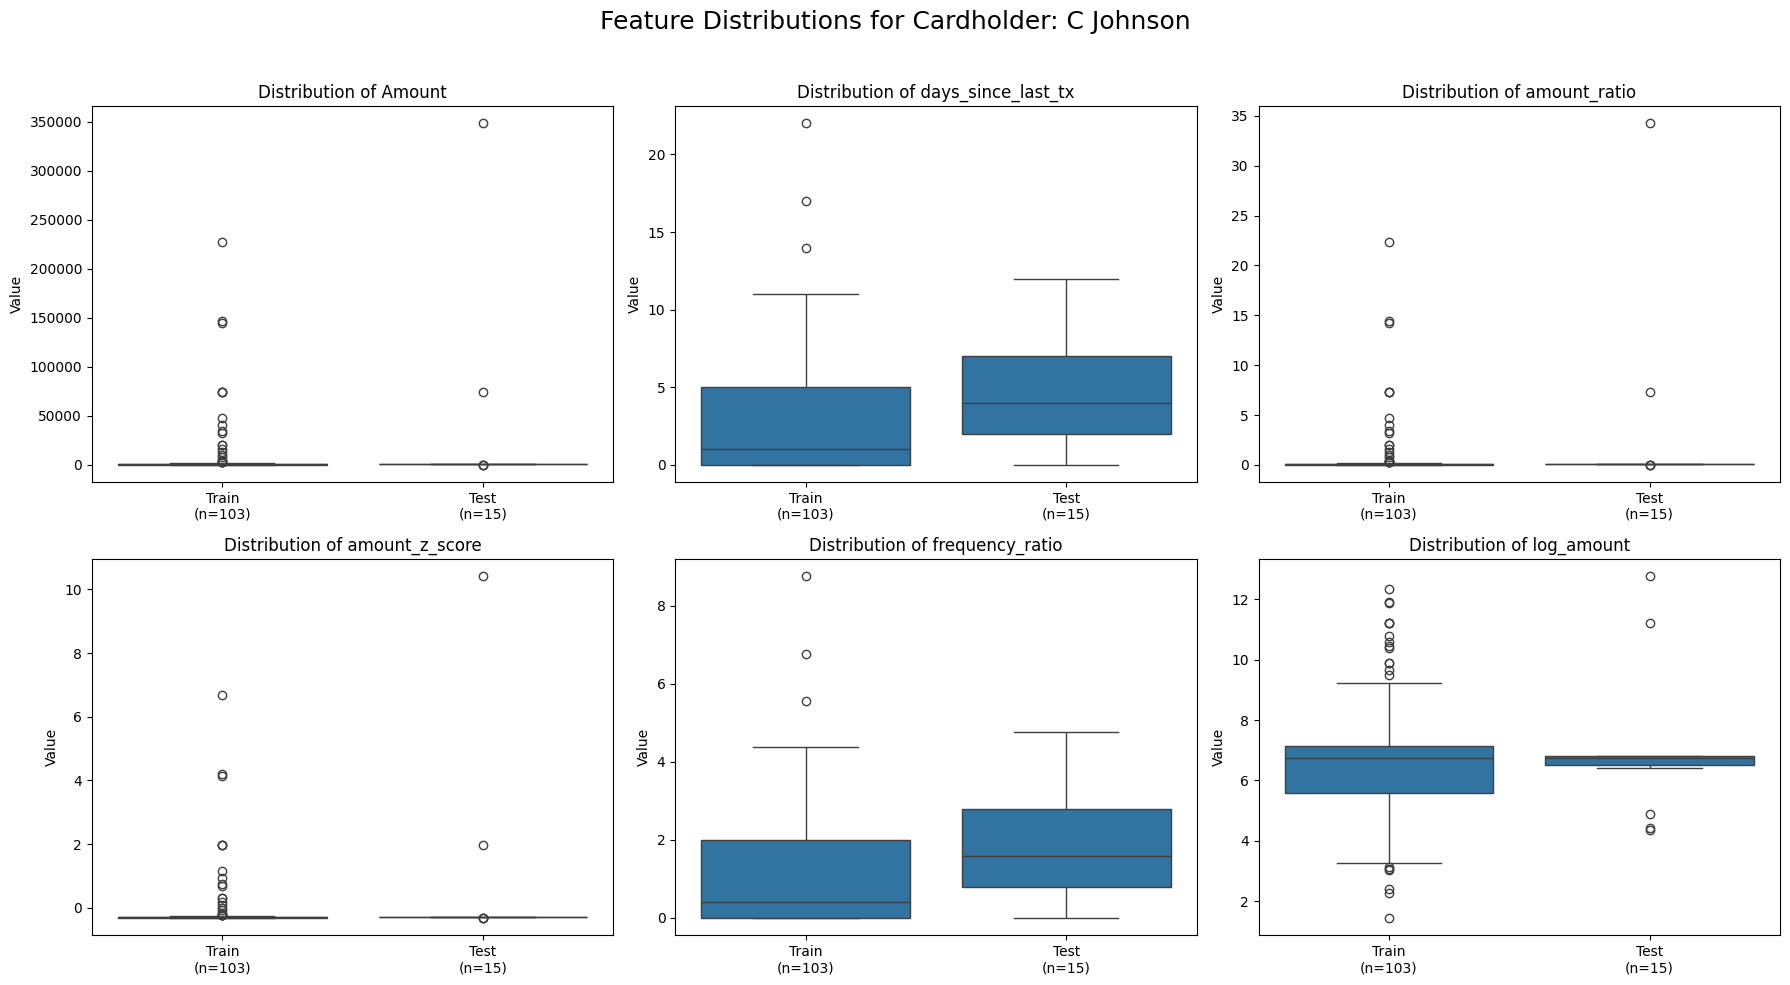

/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/2675217880.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/2675217880.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/2675217880.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])
/var/folders/2x/fz6dnkhj6959mvz1csqq0x5h0000gn/T/ipykernel_40044/2675217880.py:38: UserWarning: set_ticklabels() should only be used with a fixed number o

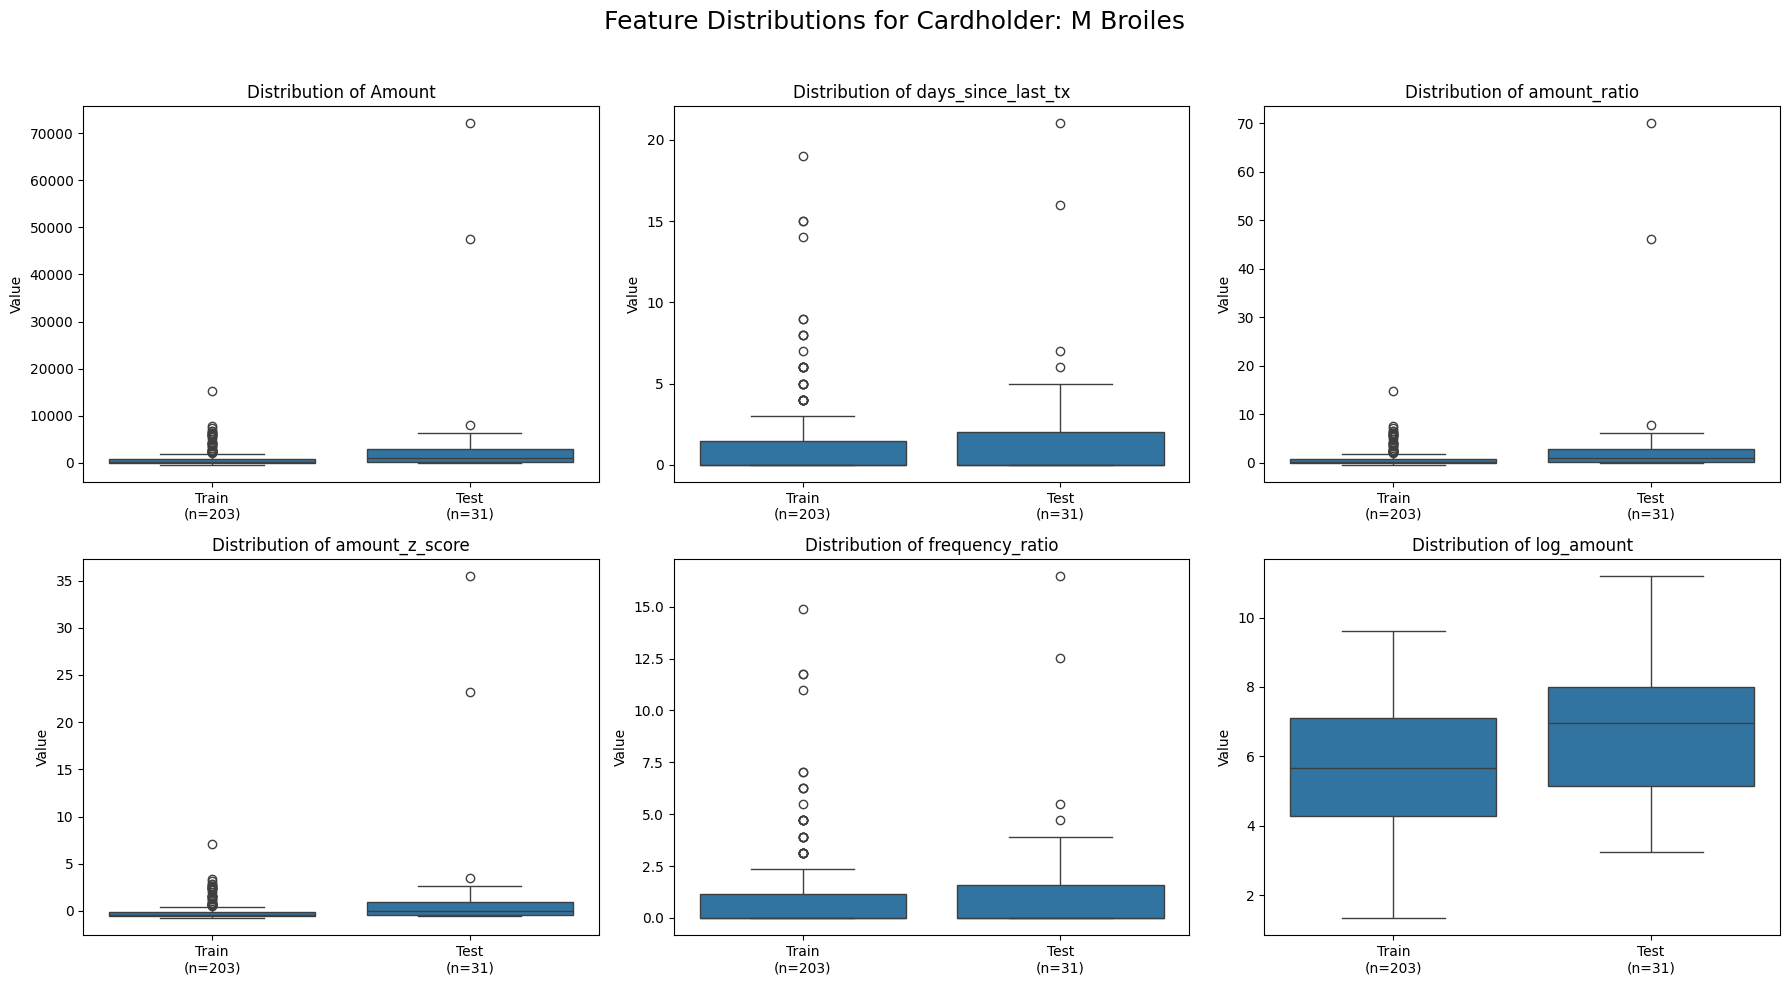

In [60]:
users_to_plot = ["C Johnson", "M Broiles"]

for user in users_to_plot:
    user_train = train_df[train_df["cardholder_full_name"] == user].copy()
    user_test = test_df[test_df["cardholder_full_name"] == user].copy()

    n_train = len(user_train)
    n_test = len(user_test)

    user_train['set'] = 'Train'
    user_test['set'] = 'Test'
    user_combined = pd.concat([user_train, user_test])

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Feature Distributions for Cardholder: {user}', fontsize=18)
    axes = axes.flatten()

    for i, feature in enumerate(final_model_features):
        ax = axes[i]
        sns.boxplot(x='set', y=feature, data=user_combined, ax=ax)
        ax.set_title(f'Distribution of {feature}')
        ax.set_xlabel('')
        ax.set_ylabel('Value')
        ax.set_xticklabels([f'Train\n(n={n_train})', f'Test\n(n={n_test})'])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

The visualizations reveal that each model flags a fundamentally different type of behavioral shift. The Isolation Forest excels at identifying transactions with extreme outlier values, especially massive purchases. For these users, their core spending pattern in the test set might look similar to their training history, but the model is flagging the emergence of new, high-magnitude events that are numerically far from their normal behavior. The Autoencoder, in contrast, is more sensitive to complete distributional shifts, where a user's entire spending pattern changes.

This leads to a critical insight: the autoencoder tends to flag users with very few transactions (a low n). While these are statistically valid anomalies (e.g., a user with a perfect spending record suddenly deviates), they are less compelling in a real-world scenario, as a cardholder with little history has not had time to establish a reliable pattern. The Isolation Forest, by flagging high-magnitude events from users with more extensive histories, proves more effective at looking past normal volatility to identify anomalies that are likely more significant.

## Limitations

Our feature engineering and modeling choices, while effective, are based on key assumptions. For instance, cardholders who appeared only in the test set had their historical statistics imputed using a global average from the training data. This necessary step assumes a new user will behave like the "average" user, which could affect the anomaly scores of their first transactions. This sensitivity to users with limited data was particularly evident with the Autoencoder, which often flagged users with very few transactions. While it correctly identified a "broken pattern," a behavioral shift for a user with only three historical transactions is arguably less meaningful than for a user with three hundred, suggesting some of its findings might be statistically correct but less practically compelling.

## Conclusion

We started with raw transaction data and successfully built a robust pipeline to engineer features and train two powerful models: an Autoencoder and an Isolation Forest. The most valuable takeaway is that these models work best as a team. The Autoencoder proved to be an expert at spotting users who broke a highly predictable spending pattern, while the Isolation Forest excelled at flagging transactions with extreme, attention-grabbing values. Ultimately, this analysis provides a starting point, not a final verdict. We've generated a targeted list of the most statistically unusual transactions, which can now be passed on for human review to make the process of finding real misuse or fraud much more efficient.